In [3]:
import pprint
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

## SETUP
# C:\MongoDB\bin\mongod.exe --dbpath=C:\MongoDB\data\db --directoryperdb
pp = pprint.PrettyPrinter()
client = MongoClient('localhost', 27017)
db = client.server

In [11]:
# pp.pprint(db.tracks.find_one({'id' : '0FwXYnBXPFaHyeG7EOjVt5'}))
# db.tracks.count_documents({})
# result = db.tracks.delete_many({'features' : None})
# print(result.deleted_count)

for item in db.tracks.find({'features' : None}):
    print(item['id'], item['name'])

In [2]:
db.tracks.count_documents({})
track = db.tracks.find_one()
pp.pprint(track)

{'_id': ObjectId('5bd61cb5edae5e837b642198'),
 'album_id': '6flam44ljzpzBPrInQJIMS',
 'artists_ids': ['3c5CN8VntREa0y3kBhNFss', '6BEqzY6INFaHKQ2mqWWuNs'],
 'disc_number': 1,
 'duration_ms': 215644,
 'explicit': False,
 'external_ids': {'isrc': 'CA5KR1555004'},
 'external_urls': {'spotify': 'https://open.spotify.com/track/2SwDlFKj3wjuNEr0LL6yzr'},
 'features': {'acousticness': 0.0161,
              'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2SwDlFKj3wjuNEr0LL6yzr',
              'danceability': 0.599,
              'duration_ms': 215645,
              'energy': 0.598,
              'id': '2SwDlFKj3wjuNEr0LL6yzr',
              'instrumentalness': 8.99e-05,
              'key': 2,
              'liveness': 0.0611,
              'loudness': -7.501,
              'mode': 1,
              'speechiness': 0.0396,
              'tempo': 128.033,
              'time_signature': 4,
              'track_href': 'https://api.spotify.com/v1/tracks/2SwDlFKj3wjuNEr0LL6yzr',
           

In [7]:
#Plot features distribution
interval_count = 10
intervals = np.arange(0, 1, 1/interval_count)
count_array = [
    ('acousticness', np.zeros(interval_count)),
    ('danceability', np.zeros(interval_count)),
    ('energy', np.zeros(interval_count)),
    ('instrumentalness', np.zeros(interval_count)),
    ('liveness', np.zeros(interval_count)),
    ('speechiness', np.zeros(interval_count)),
    ('valence', np.zeros(interval_count)),
]
values_array=[]
for track in db.tracks.find():
    item = track['features']
    values_array.append([
        item['acousticness'],
        item['danceability'],
        item['energy'],
        item['instrumentalness'],
        item['liveness'],
        item['speechiness'],
        item['valence'],
    ])
    for feature in count_array:
        value = item[feature[0]]
        norm_value =  int((value * interval_count) // 1)
        if(norm_value == interval_count):
            norm_value-=1
        feature[1][norm_value] += 1

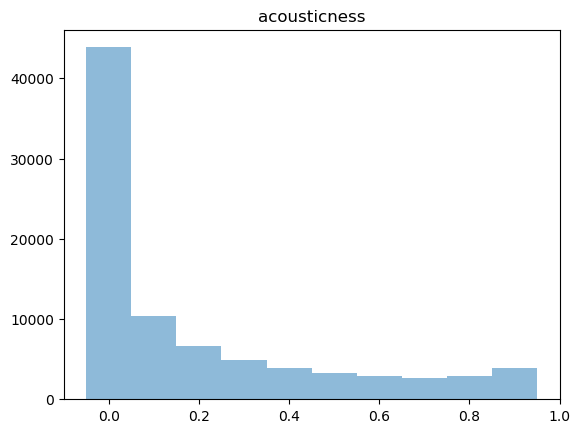

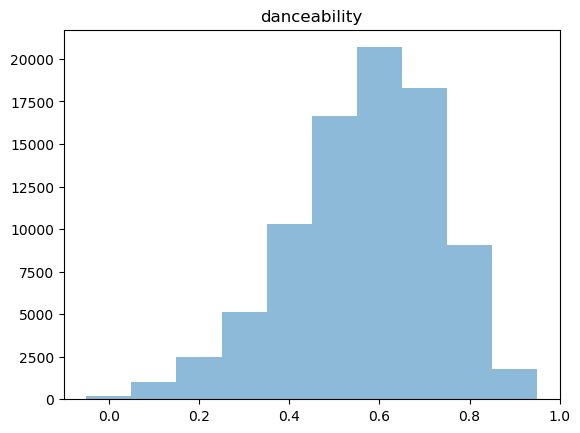

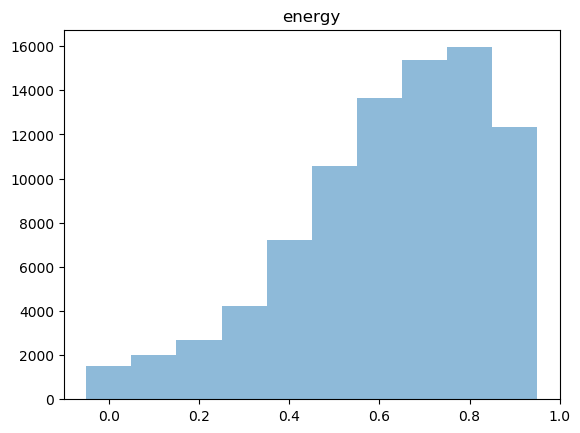

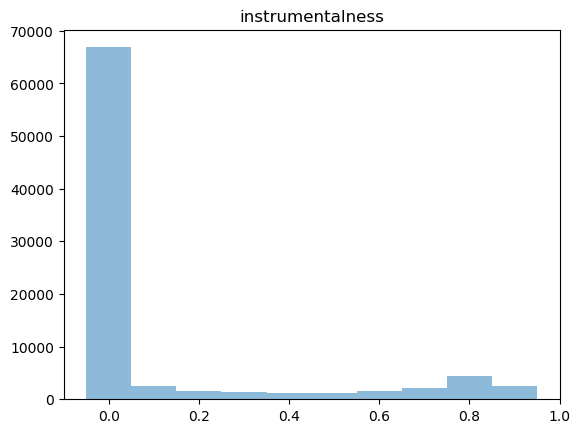

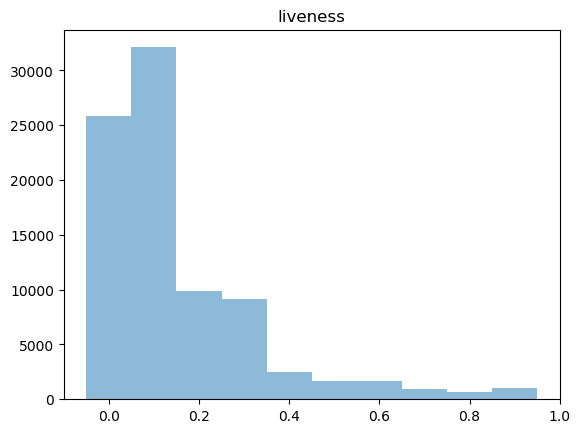

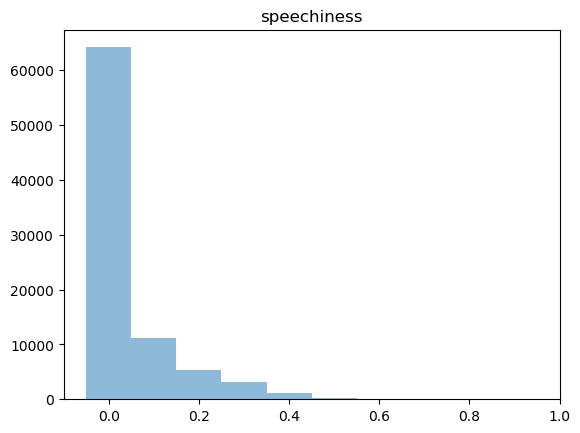

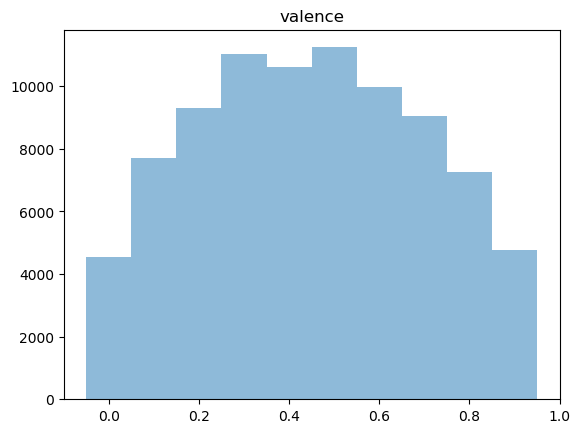

In [8]:
for array in count_array:
    plt.bar(intervals, array[1], width=1/interval_count, align='center', alpha=0.5)
    plt.title(array[0])
    plt.show()

In [88]:
def elbow_k_means(values, min_k, max_k):
    total_distances = []
    
    for n in range(min_k, max_k):
        (centroids, labels, total_distance) = k_means(values, n)
        total_distances.append(total_distance)
        print('total_distance =', total_distance)
        
    plot_elbow_k_means(total_distances, min_k, max_k)

In [81]:
def plot_elbow_k_means(total_distances, min_k, max_k):
    k_list = list(range(min_k, max_k))
    plt.plot(k_list, total_distances)
    plt.show()

In [28]:
pp.pprint(list(range(2, max_k)))

[2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.']
for i in range(len(values_array)):
    plt.plot(values_array[i][0], values_array[i][1], colors[labels[i]], markersize = 1)
    print(i, end='\r')
plt.scatter(centroids[:,0], centroids[:,1], marker = 'x', s=150, linewidths=5)
plt.show()

In [19]:
def euclidian_distance(pointA, pointB, n=7):
    distance = 0
    for i in range(n):
        distance += (pointA[i] - pointB[i]) ** 2
    
    return math.sqrt(distance)

In [18]:
len(labels)

85498

In [44]:
def sum_distances(centroids, labels, values):
    total_sum = 0
    
    for value, label in zip(values, labels):
        total_sum += euclidian_distance(value, centroids[label]) ** 2        
        
    return total_sum

In [68]:
track_ids = db.users.find_one({'id' : '12152580425'})['tracks_ids']
results = db.tracks.find({'id' : {'$in' : track_ids}})
user_tracks = []
for item in results:
    user_tracks.append(item)

In [71]:
def extract_features_from_tracks(tracks):
    features = []
    for track in tracks:
        item = track['features']
        features.append([
            item['acousticness'],
            item['danceability'],
            item['energy'],
            item['instrumentalness'],
            item['liveness'],
            item['speechiness'],
            item['valence'],
        ])
    return features

Fit done. k = 2
total_distance = 268.5060249092642
Fit done. k = 3
total_distance = 224.39895393808794
Fit done. k = 4
total_distance = 187.35837342564196
Fit done. k = 5
total_distance = 156.9995804170288
Fit done. k = 6
total_distance = 145.71420949302077
Fit done. k = 7
total_distance = 136.71175320694053
Fit done. k = 8
total_distance = 128.4291518644589
Fit done. k = 9
total_distance = 122.33883160792234
Fit done. k = 10
total_distance = 117.93336124801571
Fit done. k = 11
total_distance = 111.59882674446612
Fit done. k = 12
total_distance = 107.32283016980219
Fit done. k = 13
total_distance = 103.19903411146703
Fit done. k = 14
total_distance = 99.13511228125756
Fit done. k = 15
total_distance = 97.0474935286652
Fit done. k = 16
total_distance = 94.32683672301701
Fit done. k = 17
total_distance = 91.23230526533851
Fit done. k = 18
total_distance = 88.24962446565436
Fit done. k = 19
total_distance = 86.36993763462468
Fit done. k = 20
total_distance = 84.1650955528984
Fit done. k =

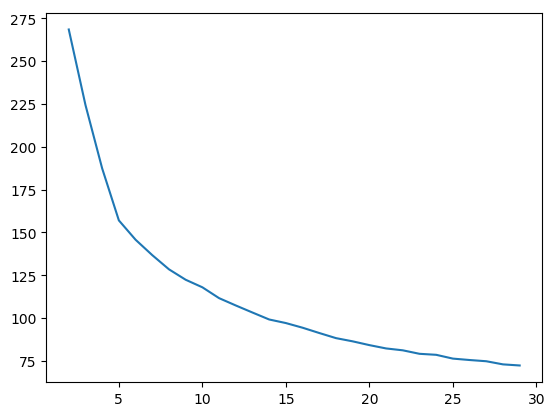

In [141]:
elbow_k_means(extract_features_from_tracks(user_tracks), 2, 30)

In [91]:
def k_means(values, k):
    clf = KMeans(n_clusters = k)
    clf.fit(values)

    print('Fit done. k =', k)

    centroids = clf.cluster_centers_
    labels = clf.labels_

    total_distance = sum_distances(centroids, labels, values)
    
    return (centroids, labels, total_distance)

Fit done. k = 10
Centroid 0 - count =  233
0 - 0.06 - F**k With U
1 - 0.067 - Talk
2 - 0.069 - I'm Still In Love With You (feat. Sasha)
3 - 0.07 - Mr. Finish Line (feat. Christine Hucal & Theo Katzman)
4 - 0.071 - Borro Cassette
5 - 0.072 - Rock Your Body
6 - 0.072 - Something New (feat. Ty Dolla $ign)
7 - 0.075 - Damaged
8 - 0.076 - Dance You Off
9 - 0.076 - Gmail


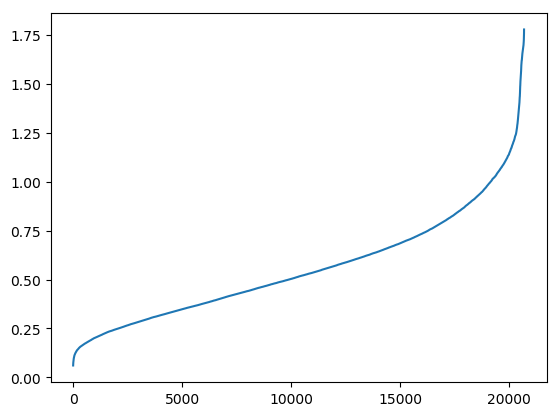

Centroid 1 - count =  263
0 - 0.063 - Ghost
1 - 0.066 - Fearless
2 - 0.066 - Disarm You (feat. Ilsey)
3 - 0.07 - Vitamin R (Leading Us Along)
4 - 0.072 - Closing Time
5 - 0.072 - Sleepwalking
6 - 0.073 - All Goes Wrong
7 - 0.075 - Shed a Tear
8 - 0.079 - Hero (feat. Josey Scott)
9 - 0.08 - Everything Zen


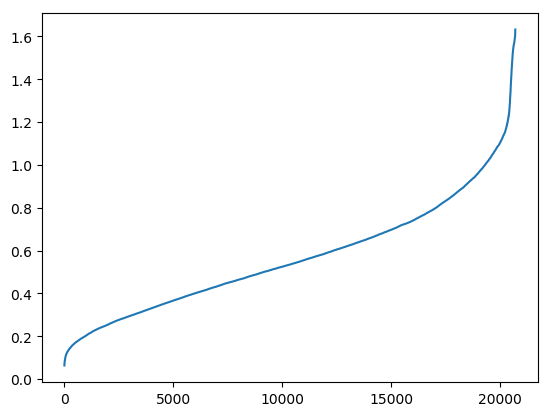

Centroid 2 - count =  76
0 - 0.133 - You Know - Radio Edit
1 - 0.141 - U Got 2 Let The Music
2 - 0.142 - King Kong (HI-LO Touch)
3 - 0.154 - Hinode
4 - 0.156 - Takeoff
5 - 0.162 - Primative People - Tale Of Us Remix
6 - 0.165 - Strangers
7 - 0.166 - Horns
8 - 0.166 - Inhaler
9 - 0.167 - Apollo


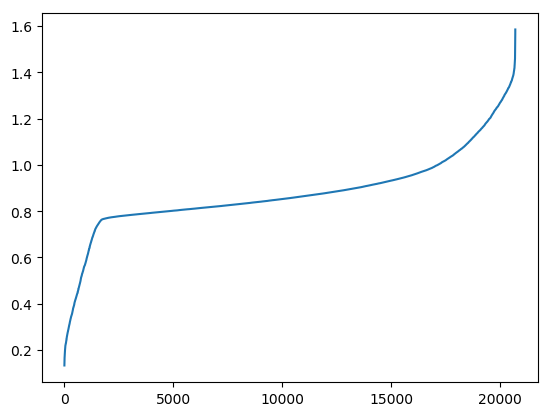

Centroid 3 - count =  292
0 - 0.056 - 1901
1 - 0.062 - Boyfriend
2 - 0.066 - CAN'T STOP THE FEELING! (Original Song from DreamWorks Animation's "TROLLS")
3 - 0.066 - Hysteria
4 - 0.067 - Backbeat
5 - 0.071 - Something Good Can Work
6 - 0.071 - Sweet Talk
7 - 0.073 - Tur Hende Hisa Man
8 - 0.075 - Alright
9 - 0.077 - Sugar (feat. Francesco Yates)


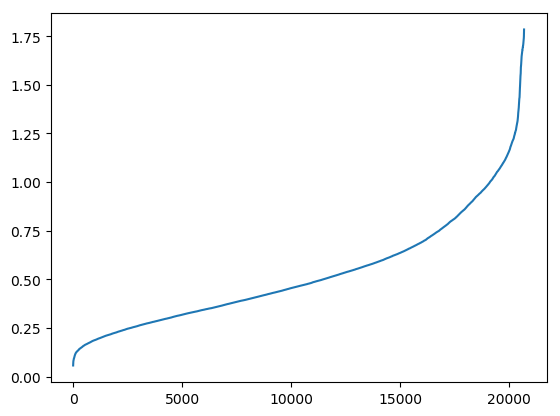

Centroid 4 - count =  55
0 - 0.111 - Taxi Lunar - Ao Vivo
1 - 0.121 - Cenário Ideal - Ao Vivo
2 - 0.124 - Atrasadinha - Ao Vivo
3 - 0.126 - Cê Topa
4 - 0.127 - Aquele Ex - Ao Vivo
5 - 0.133 - Melhor Amigo - Ao Vivo
6 - 0.135 - Perdeu o Cara Errado - Ao Vivo
7 - 0.14 - Crazy Crazy Nights
8 - 0.143 - Como Um Anjo - Ao Vivo
9 - 0.146 - Mais Amor e Menos Drama - Ao Vivo


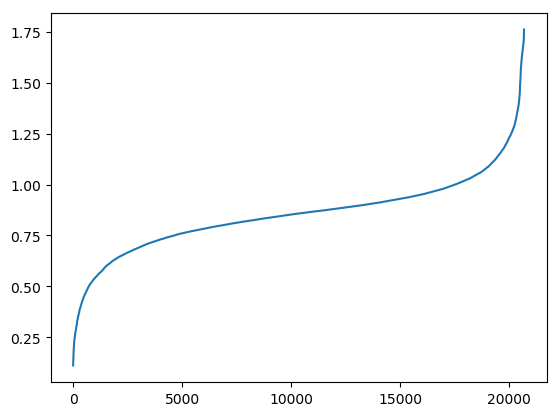

Centroid 5 - count =  245
0 - 0.048 - Blame It
1 - 0.056 - Les sables émouvants
2 - 0.059 - Freaking Out
3 - 0.06 - Love Lies - Rick Ross Remix
4 - 0.063 - Rewind
5 - 0.068 - Tired of Talking
6 - 0.069 - DaNcing in a RoOm
7 - 0.069 - Never Be The Same Again
8 - 0.069 - Truth Hurts
9 - 0.069 - Tusen Bitar


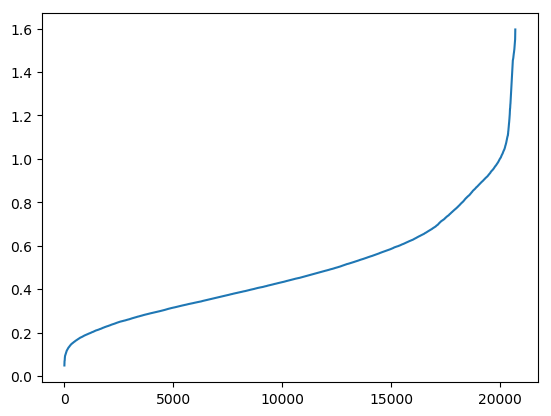

Centroid 6 - count =  111
0 - 0.081 - Bandolera
1 - 0.085 - Rockabye (feat. Sean Paul & Anne-Marie)
2 - 0.086 - Time Is Now
3 - 0.089 - Ladeira da Vida
4 - 0.108 - Baila Esta Cumbia
5 - 0.11 - Rollin
6 - 0.113 - Addicted To You
7 - 0.118 - Fifa
8 - 0.119 - I Miss You (feat. Bahari)
9 - 0.121 - No Me Enseñaste


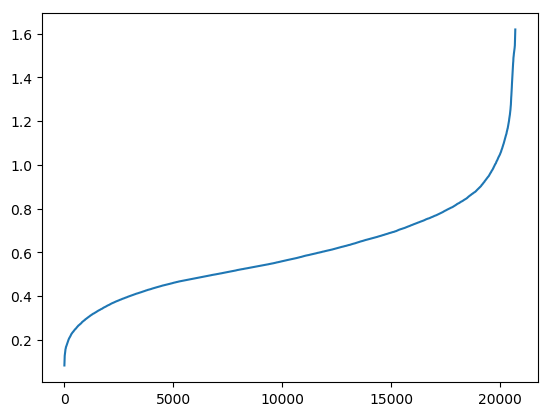

Centroid 7 - count =  15
0 - 0.171 - I Want Wind to Blow
1 - 0.184 - Hearts
2 - 0.186 - Tucana - Instrumental
3 - 0.188 - Glasshouses
4 - 0.189 - Duel of the Fates - 『スター・ウォーズ エピソード1: ファントム・メナス』より
5 - 0.204 - Shake It but Don't Break It
6 - 0.214 - The Imperial March (Darth Vader's Theme) - 『スター・ウォーズ エピソード5: 帝国の逆襲』より
7 - 0.227 - Far Nearer
8 - 0.227 - Beginner's Luck
9 - 0.231 - Begin - Recorded at Spotify Studios NYC


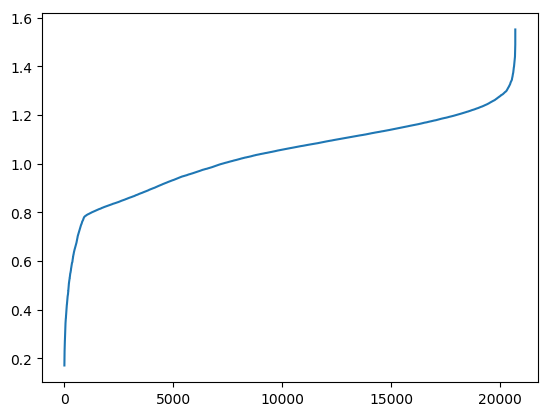

Centroid 8 - count =  88
0 - 0.067 - Lost In My Boots
1 - 0.081 - Girls Like You
2 - 0.088 - Between the Devil and the Deep Blue Sea
3 - 0.097 - One For Daddy-O - Remastered
4 - 0.101 - Cataflor
5 - 0.104 - All We Are
6 - 0.104 - I Don't Want To Talk About It
7 - 0.106 - Can't Let Go
8 - 0.107 - Hold My Girl
9 - 0.109 - Never Be the Same


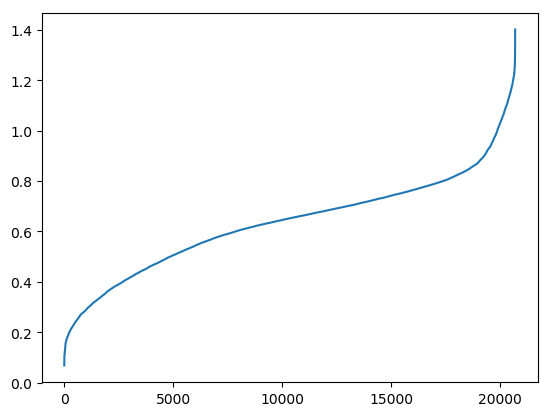

Centroid 9 - count =  95
0 - 0.071 - Straight To Hell
1 - 0.075 - Need U (100%)
2 - 0.078 - Legenden
3 - 0.091 - Tidal Wave
4 - 0.093 - Losing My Mind
5 - 0.103 - 2 Young 2 Die
6 - 0.104 - Immortals
7 - 0.113 - Scrape (feat. Gucci Mane)
8 - 0.119 - Woke Up (feat. Xuitcasecity)
9 - 0.123 - Love Is All I Got


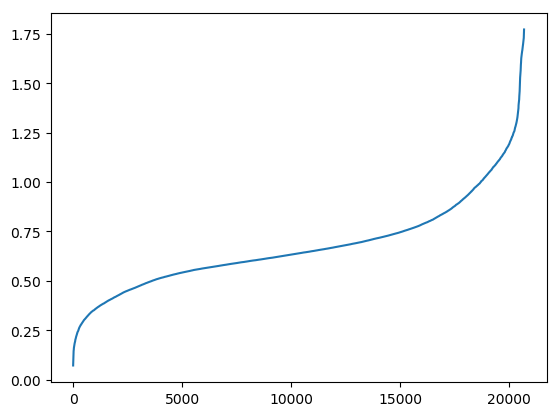

In [142]:
min_popularity = 50
(centroids, labels, total_distance) = k_means(extract_features_from_tracks(user_tracks), 10)
for i in range(len(centroids)):
    print('Centroid', i, '- count = ', list(labels).count(i))
    centroid = centroids[i]
    distance_list = []
    for track in db.tracks.find({'popularity' : {"$gte": min_popularity}}):
        item = track['features']
        feature = [
            item['acousticness'],
            item['danceability'],
            item['energy'],
            item['instrumentalness'],
            item['liveness'],
            item['speechiness'],
            item['valence'],
        ]
        distance = euclidian_distance(centroid, feature)
        distance_list.append((distance, track['popularity'], track['id'], track['name']))

    distance_list.sort()
    for j in range(10):
        print(j, '-', distance_list[j][0] // 0.001 / 1000, '-', distance_list[j][3])  
    plt.plot(list(range(len(distance_list))), [distance[0] for distance in distance_list])
    plt.show()

In [144]:
pp.pprint(distance_list[0:100])

[(0.07149656869403491, 60, '408JSy42j9aL8EMO9sPsYb', 'Straight To Hell'),
 (0.07584348114441318, 57, '08ES6fbMwR0D1tIrm8MAKg', 'Need U (100%)'),
 (0.07816955787076767, 65, '4I2mfHmpV5NP8IGH6k6sfK', 'Legenden'),
 (0.09126327323732529, 58, '3NKLPcvDM0pefpLNcmui2W', 'Tidal Wave'),
 (0.09372986494046441, 63, '6ToYObF4bq4QFgmU56vC0r', 'Losing My Mind'),
 (0.10300594656554037, 56, '4MUSaQZJ6AJdymIg0ci4HI', '2 Young 2 Die'),
 (0.10427147177971574, 75, '3Te8uLyit6X3ncNW8Fp3K2', 'Immortals'),
 (0.11307961567455499,
  56,
  '0lEuZJ8PePuU8xzyMbLInl',
  'Scrape (feat. Gucci Mane)'),
 (0.11999170466323604,
  56,
  '6F58L44zeOI950pBLyClHq',
  'Woke Up (feat. Xuitcasecity)'),
 (0.12376797731817993, 58, '1LuFyappyEFGybt2qzLNDp', 'Love Is All I Got'),
 (0.12735534715398325, 67, '6MDijuuArPJv1vbp7K1x3f', 'Genghis Khan'),
 (0.1279779355671072,
  54,
  '2ezQ7Qe2itIl6HvCbyqZXX',
  'Never Let You Go (feat. John Newman) - Jack Wins Remix'),
 (0.13254143530274046, 56, '4cgSBnNzOo9rhwzUczB7HI', 'Stone in Love'